In [1]:
import numpy as np
import random
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import copy
import itertools

In [2]:
from statsmodels.stats.multitest import multipletests

In [3]:
np.random.seed=123

In [4]:
import warnings
warnings.filterwarnings("error")

# Basic setup

## School

School $i$ is defined with fixed parametres $W, R$ and variable $\mu(s_i)$, which defines the set of students at this school

$W, R$ ~ $U[w_0, w_1], U[r_0, r_1]$

In [5]:
def resources(n):
    return ss.uniform.rvs(size=n)

In [6]:
def get_W(n):
    return np.array([ss.uniform(loc=0.000001, scale=10).rvs(size=n), ss.uniform(loc=0.000001, scale=10).rvs(size=n)])

In [7]:
def students(n):
    student = np.zeros(n)
    for i in range(n):
        student[i] = i + 1
    return student

Students will start from random allocation in schools 1 and 2. For 2 schools: 1st school is $ a_1 = \mu_{0}^1(s) \in \mathbb{F} ^2$, and 2nd school is $a_2 = \mu_{0}^2(s)= \bar{a_1}$

In [8]:
def initial_allocation(stud):
    n = len(stud)
    p = ss.uniform.rvs()
    allocation = ss.bernoulli.rvs(p, size = n)
    school1, school2 = np.zeros(n), np.zeros(n)
    for i in range(n):
        if allocation[i] == 1:
            school1[i] = 1
        else:
            school2[i] = 1
    return school1, school2

## Utility

$$ U_i = R_s \frac{w_{is}}{\sum_{j \in \mu(s)} w_{js}} $$

In [9]:
def utility(n, r, w, school1, school2):
    
    """ 
    n - student's number
    r - resource matrix
    w - weights matrix
    school1 - allocation in school 1
    school2 - allocation in school 2
    
    """
    
    if school1[n] == 1:
        utility1 = r[0] * w[0][n] / np.sum((w[0] * school1))
        utility2 = r[1] * w[1][n] / (np.sum((w[1] * school2)) + w[1][n])
    else:
        utility1 = r[0] * w[0][n] / (np.sum((w[0] * school1)) + w[0][n])
        utility2 = r[1] * w[1][n] / np.sum((w[1] * school2))
    
    return utility1, utility2

## Equilibrium check

The equilibrium condition is that for $\forall i \in s_1: U_{i1} \geq U_{i2}$. Analogously for $\forall i \in s_2$

In [10]:
def check_equilibrium(R, W, sch1, sch2):
    
    l = len(sch1)
    flag = len(sch1)
    
    for i in range(l):
        try:
            u1, u2 = utility(i, R, W, sch1, sch2)
            if ((sch1[i] != 0) and (u1 >= u2)) or ((sch2[i] != 0) and (u1 <= u2)) or ((sch1[i] == 0) and (sch2[i] == 0)):
                flag -= 1
        except RuntimeWarning:
            flag -= 1
            continue
            
    if flag == 0:
        return 1
    else:
        return 0

# Absence of uniqueness

In [11]:
def check_all_eq(n):
    
    R = resources(2)
    W = get_W(n)
    
    
    lst = list(map(list, itertools.product([0, 1], repeat=n)))
    
    num_of_eqs = 0
    
    eqs = []
    
    for i in range(len(lst)):
        sch1 = np.array(lst[i])
        sch2 = np.ones(n) - sch1
        
        check_in = check_equilibrium(R, W, sch1, sch2)
        num_of_eqs += check_in
        
        if check_in == 1:
            eqs.append(sch1)
        

    return num_of_eqs, eqs, R, W

In [12]:
st = 0 
n = 4
while st != 5:
    R = resources(n)
    W = get_W(n)
    res = check_all_eq(n)
    st = res[0]
    
res

(5,
 [array([0, 0, 1, 1]),
  array([0, 1, 0, 1]),
  array([0, 1, 1, 0]),
  array([1, 0, 0, 1]),
  array([1, 0, 1, 0])],
 array([0.76461217, 0.7184986 ]),
 array([[8.80961806, 6.97121588, 6.72766138, 6.56816523],
        [6.49090281, 7.23300664, 8.91862107, 3.99382906]]))

Not uniqueness in general case of equlibrium is prooved by counterexample for 4 students.

# Welfare and Inequality

$W= \sum_1^n \sqrt{u_i} $

In [13]:
def get_welfare_school(R, W, sch):
    down = np.sum(W * sch)
    
    if down != 0:
        return np.sum(np.sqrt(R * W / down) * sch)
    else:
        return 0

In [14]:
def get_welfare_school_row(R, W, sch):
    down = np.sum(W * sch)
    
    sample = np.sqrt(R * W / down) * sch
    sample = sample[sample > 0]
    return sample


In [15]:
def get_gini(arr):
    g = 0
    peps = len(arr)
    arr = sorted(arr)
    rel_inc = np.cumsum(arr / np.sum(arr))
    
    for i in range(peps - 1):
        g += 1 / peps * (rel_inc[i]+rel_inc[i+1])
        
    G = abs(1 - g)
    return G, rel_inc

## Uniform distribution of $W, R$,  no $u_0$

The set of strategies $\forall i \in I = \{s_1, s_2\}$

In [16]:
def naive_strategy_1(n, r, w, school1, school2):
    u1, u2 = utility(n, r, w, school1, school2)
    
    if (school1[n] != 0) and (u2 > u1):
        school1[n] = 0
        school2[n] = 1
    elif (school2[n] != 0) and (u2 < u1):
        school1[n] = 1
        school2[n] = 0
    return school1, school2

In [17]:
def sim_welf_1(R, W, stud, r1, n):
    
    sch1, sch2 = initial_allocation(students(n))
            
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2 = naive_strategy_1(person, R, W, sch1, sch2) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1

    sch1, sch2 = np.array(sch1), np.array(sch2)
    
    
    log_u_1 = get_welfare_school(R[0], W[0], sch1)
    log_u_2 = get_welfare_school(R[1], W[1], sch2)
    
    welfare = log_u_1 + log_u_2
    
    return welfare

In [18]:
def simulation_short_uniform_sq_spread(r1, n, folds, increment=0.1, r2=10):
    
    """ 
    
    r1 - ресурсы в элитной школе (во второй школе ресурсы будут всегда 1, поэтому мы их зафиксируем)
    n - кол-во школьников
    folds - кол-во разбиений
    
    """
    
    R = np.array([r1 + r2, r1 + r2])
    W = get_W(n)
        
    stud = students(n)
    
    # let's vary the R
    
    all_welf = np.zeros(folds - 1)
    
    for i in range(1, folds):
        delta = i / folds
        R_sample = R * np.array([delta, (1 - delta)])
        welfare = sim_welf_1(R_sample, W, stud, r1, n)
        all_welf[i - 1] = welfare
    
    return all_welf[1:folds], np.argmax(all_welf[1:folds-1])

## How can we Welfare $\rightarrow max$ for fixed amount of resources?

Whereever we inroduce a policy, we apply it to the *previous equilibrium*

Let's keep $R_1 + R_2 = R_0$ where $R_0 \in \mathbb{R}_+$ 

$R_1 = 40, R_2 = 10, n = 20$

62


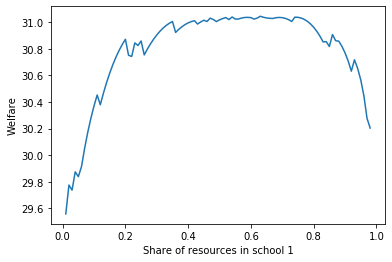

In [175]:
res = simulation_short_uniform_sq_spread(40, 20, 100)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(np.array(range(1, 99)) / 100, res[0])

We see some kind of a parabola that shows that welfare maximizes at $R_1 \backsimeq R_2$

Take a look at the distribution of $\text{argmax}(W)$

In [176]:
perm = 1000
all_max_r1_to_r2 = np.zeros(perm)
for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_spread(40, 20, 100)
    all_max_r1_to_r2[i] = res[1]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:49<00:00,  1.01s/it]


(array([ 17.,  44.,  95., 166., 201., 234., 117.,  77.,  33.,  16.]),
 array([0.   , 0.097, 0.194, 0.291, 0.388, 0.485, 0.582, 0.679, 0.776,
        0.873, 0.97 ]),
 <a list of 10 Patch objects>)

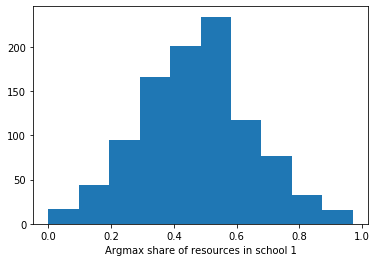

In [180]:
plt.xlabel("Argmax share of resources in school 1")
plt.hist(all_max_r1_to_r2 / 100)

In [20]:
def simulation_short_uniform_with_reserved_sq_folds(r1, n, u0, increment=0.1, r2=10, folds=100):
    
    """ 
    r1 - resources in the richer school
    n - numner of students
    u0 - reserve utility 
    
    """
    
    R = np.array([r1+r2, r1+r2])
    W = get_W(n)
        
    stud = students(n)
    
    all_welfare = np.zeros(folds-1)
    
    for i in range(1, folds-1):
        try:
            delta = i / folds
            R_sample = R * np.array([delta, 1 - delta])
            all_welfare[i] = sim_welf_uniform_reserve(R_sample, W, stud, n, u0)
        except RuntimeWarning:
            all_welfare[i] = np.sqrt(u0) * n
            continue

    ans = all_welfare[all_welfare > 0]
    return ans[:folds // 2], np.argmax(ans) / folds

In [21]:
def another_naive_strategy(n, r, w, school1, school2, loosers, u0):
    
    '''
    loosers - the vector of school leavers
    '''
    
    u1, u2 = utility(n, r, w, school1, school2)
    
    if max(u1, u2) < u0:
        school1[n], school2[n], loosers[n] = 0, 0, 1
        
    if (school1[n] != 0) and (u2 > u1):
        school1[n] = 0
        school2[n] = 1
    elif (school2[n] != 0) and (u2 < u1):
        school1[n] = 1
        school2[n] = 0
        
    return school1, school2, loosers

In [22]:
def sim_welf_uniform_reserve(R, W, stud, n, u_0):
    
    sch1, sch2 = initial_allocation(students(n))
        
    list_of_quits = np.zeros(n)
        
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2, list_of_quits = another_naive_strategy(person, R, W, sch1, sch2, list_of_quits, u_0) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1

    sch1, sch2 = np.array(sch1), np.array(sch2)
    
    num_students_left = np.sum(list_of_quits)
    
    log_u_1 = get_welfare_school(R[0], W[0], sch1)
    log_u_2 = get_welfare_school(R[1], W[1], sch2)
    log_u_left = get_welfare_left(u_0, num_students_left)
        
    welfare = max(log_u_1 + log_u_2 + log_u_left, np.sqrt(u_0) * n)
    
    return welfare

In [23]:
def get_welfare_left(u0, n):
    return np.sum(n * np.sqrt(u0))

In [24]:
def get_welfare_left_row(u0, n):
    return np.array(int(n) * [u0])

Let's change only $u_0$, keeping everything else fixed. Because the task is symmetrical ommiting the non-uniqueness of the equilibrium, we will pay attention to the share of resources in first school $ t \in(0, 0.5]$

In [25]:
x = np.array(range(1, 1001)) / 2000

0.349


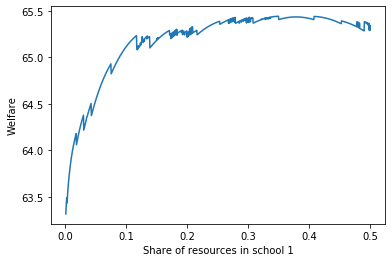

In [26]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 0, folds=2000)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

We see that the welfare increases with the increase of $t$

## How can we Welfare $\rightarrow max$ if we can allocate more resource to one of the schools?

In [27]:
def simulation_short_uniform_sq_pluses(r1, n, all_increments = np.array(range(1, 15+1)) / 100, r2=10):
    
    R = np.array([r1, r2])
    W = get_W(n)
        
    stud = students(n)
    
    # no policy

    welfare = sim_welf_1(R, W, stud, r1, n)
    
    # implication
                                  
    l = len(all_increments)
                              
    all_plus_fix = np.zeros(l) 
    all_diffs_fix = np.zeros(l)
    
    for i in range(l):
                              
        increment = all_increments[i]
    
        # investment
        delta = np.sum(R) * increment

        R1 = np.array([R[0] + delta, R[1]])
        R2 = np.array([R[0], R[1] + delta])

        welfare1 = sim_welf_1(R1, W, stud, r1, n)

        welfare2 = sim_welf_1(R2, W, stud, r1, n)

        plus1 = welfare1 - welfare
        plus2 = welfare2 - welfare

        diff_plus = welfare1 - welfare2

        all_plus_fix[i], all_diffs_fix[i] = max(plus1, plus2), diff_plus
                              
    return all_plus_fix, all_diffs_fix

In [28]:
x = np.array(range(1, 40)) / 100

Now we will keep matrices $W, R$ fixed and vary the amount of resource $\delta$ that we can add to one of the schools.

$\delta$ is some increment that we can allocate to one of two schools.$\Delta(W) = max(W_1, W_2) - W_0$, where $W_0$ denotes the welfare of initial allocation, and $W_1, W_2$ denote the welfare in case of addition of the $\delta$ to school 1, school2, respectively. 

 
$$ \delta = \alpha (R_1 + R_2) $$
where $\alpha$ it the increment in the previous code

The following histogramm shows that $\Delta$ rises with the addition of $\delta$, which is quite logical as we add more resources to the system.

**Case 1**
$R_1 = 2R_2$

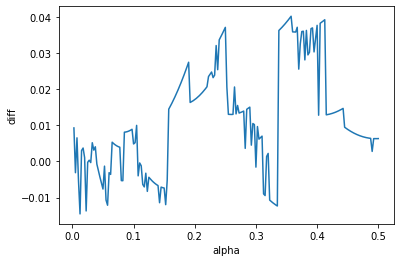

In [184]:
res = simulation_short_uniform_sq_pluses(20, 40, all_increments=x)
plt.xlabel("alpha")
plt.ylabel("diff")
plt.plot(x, res[1])

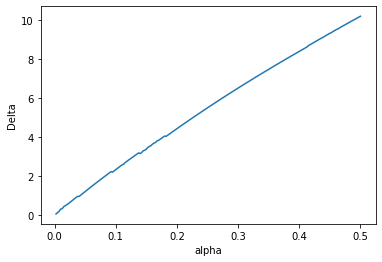

In [183]:
plt.xlabel("alpha")
plt.ylabel("Delta")
plt.plot(x, res[0])

**Case 1**
$R_1 = 4R_2$

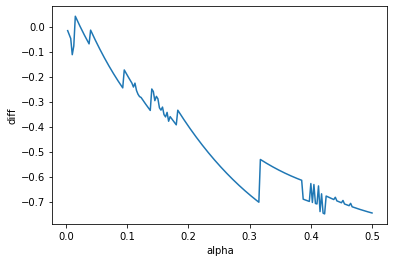

In [179]:
res = simulation_short_uniform_sq_pluses(40, 40, all_increments=x)
plt.xlabel("alpha")
plt.ylabel("diff")
plt.plot(x, res[1])

Now it is easier to see a trend that investment to the poor school provides a higher welfare boost.

**Is it true that for small $\delta$ there is no difference where to invest or maybe it is profitable to invest into the 2nd school?** (no $u_0$)

We will also use bootstrap to estimate the probability of poor school investment being profitable. 

In [31]:
x = np.array(range(1, 10)) / 1000

$R_1 = 20, R_2 = 10, \alpha\in \{0.01, 0.05, 0.1\}$ 

In [32]:
perm = 1000
all_diff_uni_small = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(20, 40, all_increments=np.array([0.01]))
    all_diff_uni_small[i] = np.max(res[1])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:07<00:00,  4.03it/s]


(array([  1.,   6.,  42., 267., 334., 196.,  84.,  42.,  19.,   9.]),
 array([-0.08554999, -0.06920037, -0.05285074, -0.03650112, -0.0201515 ,
        -0.00380188,  0.01254775,  0.02889737,  0.04524699,  0.06159661,
         0.07794623]),
 <a list of 10 Patch objects>)

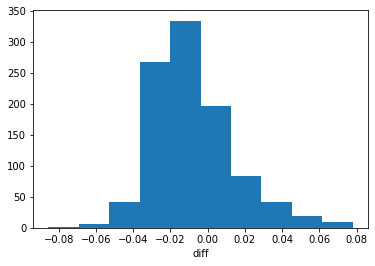

In [33]:
plt.xlabel("diff")
plt.hist(all_diff_uni_small)

In [34]:
len(all_diff_uni_small[all_diff_uni_small < 0]) / perm

0.705

In [35]:
perm = 1000
all_diff_uni_small = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(20, 40, all_increments=np.array([0.05]))
    all_diff_uni_small[i] = np.max(res[1])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


(array([  5.,  12.,  20.,  43.,  92., 193., 276., 309.,  44.,   6.]),
 array([-0.19536331, -0.16999634, -0.14462938, -0.11926242, -0.09389545,
        -0.06852849, -0.04316153, -0.01779456,  0.0075724 ,  0.03293936,
         0.05830633]),
 <a list of 10 Patch objects>)

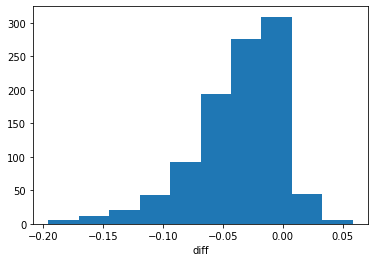

In [36]:
plt.xlabel("diff")
plt.hist(all_diff_uni_small)

In [37]:
len(all_diff_uni_small[all_diff_uni_small < 0]) / perm

0.864

In [38]:
perm = 1000
all_diff_uni_small = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(20, 40, all_increments=np.array([0.1]))
    all_diff_uni_small[i] = np.max(res[1])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:07<00:00,  4.04it/s]


(array([  2.,   3.,   7.,  12.,  44., 108., 247., 389., 180.,   8.]),
 array([-0.42631748, -0.37496972, -0.32362196, -0.2722742 , -0.22092643,
        -0.16957867, -0.11823091, -0.06688315, -0.01553539,  0.03581238,
         0.08716014]),
 <a list of 10 Patch objects>)

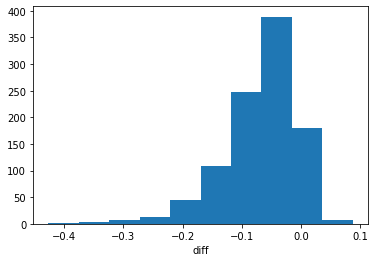

In [39]:
plt.xlabel("diff")
plt.hist(all_diff_uni_small)

In [40]:
len(all_diff_uni_small[all_diff_uni_small < 0]) / perm

0.93

$R_1 = 100, R_2 = 10, \delta \in \{0.01, 0.05, 0.1\}$ 

Now we increase the resource inequality between schools by increasing $R_1$ by five times.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:35<00:00,  4.64it/s]

729


(array([ 25.,  88., 213., 221.,  93.,  91., 120.,  96.,  43.,  10.]),
 array([-2.72530323e-01, -2.27072602e-01, -1.81614880e-01, -1.36157159e-01,
        -9.06994370e-02, -4.52417154e-02,  2.16006191e-04,  4.56737278e-02,
         9.11314494e-02,  1.36589171e-01,  1.82046893e-01]),
 <a list of 10 Patch objects>)

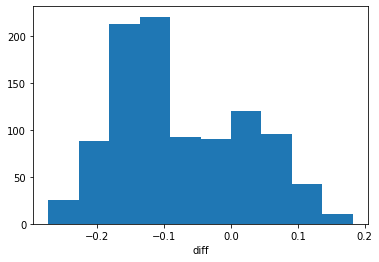

In [41]:
perm = 1000
all_diff_uni = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(100, 40, all_increments=np.array([0.01]))
    all_diff_uni[i] = np.max(res[1])
    
print(len(all_diff_uni[all_diff_uni < 0]) / perm)
plt.xlabel("diff")
plt.hist(all_diff_uni)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.57it/s]

985


(array([  2.,  18.,  37.,  68., 122., 175., 238., 203., 109.,  28.]),
 array([-0.98433604, -0.87729942, -0.7702628 , -0.66322617, -0.55618955,
        -0.44915293, -0.34211631, -0.23507969, -0.12804306, -0.02100644,
         0.08603018]),
 <a list of 10 Patch objects>)

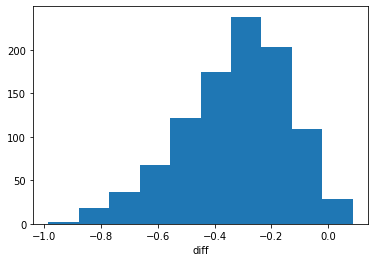

In [42]:
perm = 1000
all_diff_uni = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(100, 40, all_increments=np.array([0.05]))
    all_diff_uni[i] = np.max(res[1])
    
print(len(all_diff_uni[all_diff_uni < 0]) / perm)
plt.xlabel("diff")
plt.hist(all_diff_uni)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:57<00:00,  4.21it/s]

999


(array([  6.,   3.,  24.,  45., 117., 170., 245., 221., 136.,  33.]),
 array([-1.62018798, -1.45755265, -1.29491732, -1.13228199, -0.96964667,
        -0.80701134, -0.64437601, -0.48174068, -0.31910535, -0.15647002,
         0.0061653 ]),
 <a list of 10 Patch objects>)

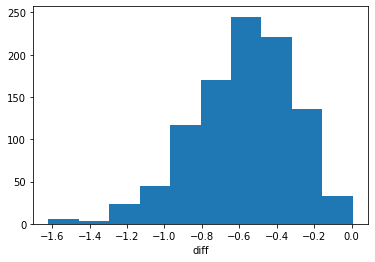

In [43]:
perm = 1000
all_diff_uni = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq_pluses(100, 40, all_increments=np.array([0.1]))
    all_diff_uni[i] = np.max(res[1])
    
print(len(all_diff_uni[all_diff_uni < 0]) / perm)
plt.xlabel("diff")
plt.hist(all_diff_uni)

We see that the $\text{diff}$ decreases with increase of $\delta$ and with the increase of resource inequlity between schools. But what is more important, we may notice examples of positive $\text{diff}$, which means that in some cases it is more profitable to invest in the richer school due to discreteness of the model

## If there is $u_0$

Now players have some reserve utility $u_0$. If player's $max(u_1, u_2) < u_0$ then he can leave school

In [44]:
def simulation_short_uniform_sq(r1, n, increment=0.1, r2=10):
    
    """ 
    r1 - ресурсы в элитной школе (во второй школе ресурсы будут всегда 1, поэтому мы их зафиксируем)
    n - кол-во школьников
    
    """
    
    R = np.array([r1, r2])
    W = get_W(n)
    # W = binom_weights_2_groups_ege(smart, p1, p2, tasks, n)
        
    stud = students(n)
    
    # если ничего не делаем

    welfare = sim_welf_1(R, W, stud, r1, n)
    
    # прибавка
    delta = np.sum(R) * increment
            
    # кладем delta в школу 1
    R1 = np.array([R[0] + delta, R[1]])
    R2 = np.array([R[0], R[1] + delta])
    
    welfare1 = sim_welf_1(R1, W, stud, r1, n)
    
    # кладем delta в школу 2
        
    welfare2 = sim_welf_1(R2, W, stud, r1, n)
    
    plus1 = welfare1 - welfare
    plus2 = welfare2 - welfare
    
    diff_plus = welfare1 - welfare2
            
    return max(plus1, plus2), diff_plus

In [45]:
perm = 100

all_welfare = np.zeros(perm)
all_diffs_welfare = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_sq(20, 40, increment=0.01)
    all_welfare[i] = res[0]
    all_diffs_welfare[i] = res[1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.83it/s]


$\delta$ is some increment that we can allocate to one of two schools.$\Delta(W) = max(W_1, W_2) - W_0$, where $W_0$ denotes the welfare of initial allocation, and $W_1, W_2$ denote the welfare in case of addition of the $\delta$ to school 1, school2, respectively. 

 
$$ \delta = \alpha (R_1 + R_2) $$
where $\alpha$ it the increment in the previous code

The following histogramm shows that $\Delta$ rises with the addition of $\delta$, which is quite logical as we add more resources to the system.

(array([ 7., 27., 34., 24.,  3.,  1.,  0.,  1.,  2.,  1.]),
 array([0.15011917, 0.16112803, 0.17213688, 0.18314574, 0.19415459,
        0.20516345, 0.2161723 , 0.22718116, 0.23819001, 0.24919887,
        0.26020772]),
 <a list of 10 Patch objects>)

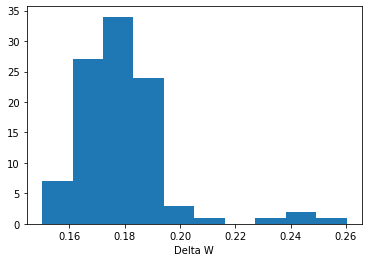

In [46]:
plt.xlabel("Delta W")
plt.hist(all_welfare)

The second hystogramm shows the distribution of $W_1 - W_2$. We see that it can be positive, which means that due to discrete effects it is profitable to increase the inequality between 2 schools for relatively small $\delta$. It is counterintuitive to some extent

(array([ 1.,  0.,  8., 19., 36., 18., 10.,  5.,  1.,  2.]),
 array([-0.07279359, -0.05916898, -0.04554437, -0.03191976, -0.01829515,
        -0.00467054,  0.00895407,  0.02257869,  0.0362033 ,  0.04982791,
         0.06345252]),
 <a list of 10 Patch objects>)

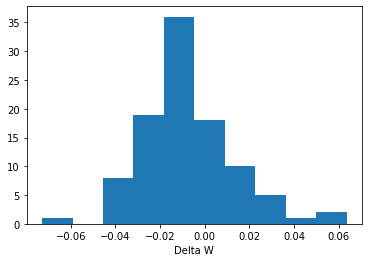

In [47]:
plt.xlabel("Delta W")
plt.hist(all_diffs_welfare)

With the introduction of $u_0$ we obtained the same results as for the model without $u_0$

## Gini coefficient

In [48]:
def sim_gini_uniform(R, W, r1, n):
    
    sch1, sch2 = initial_allocation(students(n))
        
    list_of_quits = np.zeros(n)
        
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2 = naive_strategy_1(person, R, W, sch1, sch2) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1

    sch1, sch2 = np.array(sch1), np.array(sch2)
        
    sch1_ut = get_welfare_school_row(R[0], W[0], sch1)
    sch2_ut = get_welfare_school_row(R[1], W[1], sch2)
            
    return np.concatenate((sch1_ut, sch2_ut))

In [49]:
def simulation_short_uniform_gini(r1, n, r2=10):
    
    """ 
    tasks - количество задач в экзамене
    r1 - ресурсы в элитной школе (во второй школе ресурсы будут всегда 1, поэтому мы их зафиксируем)
    n - кол-во школьников
    """
    
    R = np.array([r1, r2])
    W = get_W(n)
        
    stud = students(n)
    
    all_uts = sim_gini_uniform(R, W, r1, n)
    gini, all_rel_uts = get_gini(all_uts)
        
    return gini, all_rel_uts

0.11774458073688743


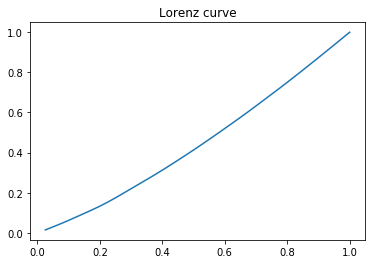

In [50]:
r1, n = 30, 40
res = simulation_short_uniform_gini(r1, n)
print(res[0])
x = np.array(range(1, n + 1)) / n
plt.title('Lorenz curve')
plt.plot(x, res[1])

In [51]:
perm = 1000
all_gini = np.zeros(perm)
for i in tqdm(range(perm)):
    res = simulation_short_uniform_gini(r1, n)
    all_gini[i] = res[0]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:01<00:00,  8.25it/s]


(array([ 12.,  62., 214., 319., 247., 109.,  27.,   9.,   0.,   1.]),
 array([0.070555  , 0.08544629, 0.10033759, 0.11522888, 0.13012018,
        0.14501147, 0.15990276, 0.17479406, 0.18968535, 0.20457665,
        0.21946794]),
 <a list of 10 Patch objects>)

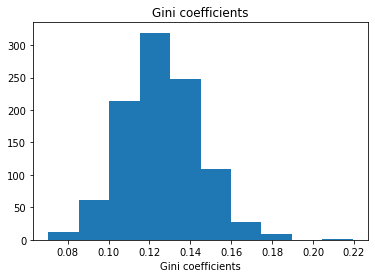

In [52]:
plt.xlabel('Distribution gini coefficients')
plt.title('Gini coefficients')
plt.hist(all_gini)

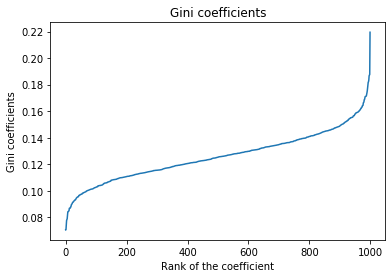

In [53]:
plt.xlabel('Rank of the coefficient')
plt.ylabel('Gini coefficients')
plt.title('Gini coefficients')
plt.plot(sorted(all_gini))

## Gini in schools, between schools, total (no $u_0$)

In [54]:
def sim_gini_uniform(R, W, stud, r1, n):
    
    sch1, sch2 = initial_allocation(students(n))
                
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2 = naive_strategy_1(person, R, W, sch1, sch2) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1
        
    sch1, sch2 = np.array(sch1), np.array(sch2)
        
    sch1_ut = get_welfare_school_row(R[0], W[0], sch1)
    sch2_ut = get_welfare_school_row(R[1], W[1], sch2)
            
    return sch1_ut, sch2_ut, np.concatenate((sch1_ut, sch2_ut)), sch1, sch2, W, R 

In [55]:
def sim_gini_uniform_from_fixed_school(R, W, stud, r1, n, school_1):
    
    sh1, sh2 = school_1, np.ones(n) - school_1
                
    check = check_equilibrium(R, W, sh1, sh2)
    
    j = 0
    while check != 1:
        person = j % n 
        sh1, sh2 = naive_strategy_1(person, R, W, sh1, sh2) 
        check = check_equilibrium(R, W, sh1, sh2)
        j += 1
        
    # print(check)
        
    sh1, sh2 = np.array(sh1), np.array(sh1)
        
    sch1_ut = get_welfare_school_row(R[0], W[0], sh1)
    sch2_ut = get_welfare_school_row(R[1], W[1], sh2)
            
    return sch1_ut, sch2_ut, np.concatenate((sch1_ut, sch2_ut)), sh1, sh2, W, R

In [56]:
def simulation_short_uniform_gini(r1, n, r2=10):
    
    R = np.array([r1, r2])
    W = get_W(n)
        
    stud = students(n)
    
    sch1_uts, sch2_uts, all_uts, sc1, sc2, W, R = sim_gini_uniform(R, W, stud, r1, n)
    
    sch1_gini, sch1_rel_uts = get_gini(sch1_uts)
    sch2_gini, sch2_rel_uts = get_gini(sch2_uts)
    all_gini, all_rel_uts = get_gini(all_uts)
    
    W_egalite = np.array([np.ones(n), np.ones(n)])
    welf_sch1_egalite = get_welfare_school_row(R[0], W_egalite[0], sc1)
    welf_sch2_egalite = get_welfare_school_row(R[1], W_egalite[1], sc2)
    welf_all_egalite = np.concatenate((welf_sch1_egalite, welf_sch2_egalite))
    gini_egalite = get_gini(welf_all_egalite)[0]
    
    welfare = np.sum(all_uts)    
        
    return sch1_gini, sch2_gini, all_gini, gini_egalite, welfare, sc1, W, R

In [57]:
def simulation_short_uniform_gini_delta(W, R, n, schoo1, r2=10):
        
    stud = students(n)
        
    sch1_uts, sch2_uts, all_uts, scho1, scho2, W, R = sim_gini_uniform_from_fixed_school(R, W, stud, r1, n, schoo1)
    
    sch1_gini, sch1_rel_uts = get_gini(sch1_uts)
    sch2_gini, sch2_rel_uts = get_gini(sch2_uts)
    all_gini, all_rel_uts = get_gini(all_uts)
    
    W_egalite = np.array([np.ones(n), np.ones(n)])
    welf_sch1_egalite = get_welfare_school_row(R[0], W_egalite[0], scho1)
    welf_sch2_egalite = get_welfare_school_row(R[1], W_egalite[1], scho2)
    welf_all_egalite = np.concatenate((welf_sch1_egalite, welf_sch2_egalite))
    gini_egalite = get_gini(welf_all_egalite)[0]
    
    welfare = np.sum(all_uts)
    
        
    return sch1_gini, sch2_gini, all_gini, gini_egalite, welfare, scho1, W, R

In [58]:
def checker_array(arr1, arr2):
    flag = 1
    
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            flag = 0
    return flag

In [148]:
r = 30
n = 5
increment = 0.2

In [100]:
perm = 100

for i in tqdm(range(perm)):

    res_0 = simulation_short_uniform_gini(r, n)
    W_fixed = res_0[-2]
    sch1_first_stage = res_0[-3]
    
    res_0_out = copy.deepcopy(res_0)

    delta_fixed = increment * (10 + r)
    R1 = np.array([r, 10]) + np.array([delta_fixed, 0])
    R2 = np.array([r, 10]) + np.array([0, delta_fixed])

    res_delta_to_sch1 = simulation_short_uniform_gini_delta(W_fixed, R1, n, sch1_first_stage)
    res_delta_to_sch2 = simulation_short_uniform_gini_delta(W_fixed, R2, n, sch1_first_stage)
    
    if (checker_array(res_0_out[-3], res_delta_to_sch2[-3]) == 0) and (np.sum(res_0_out[-3]) < n - 1):        
        break

 11%|████████▊                                                                       | 11/100 [00:00<00:00, 169.92it/s]


Example where after the addition of resource to the school 2:
- inequality in school1 increased
- inequality in school2 decreased
- inequality between schools decreased
- total inequality decreased

In [101]:
res_0_out

(0.1652763912245021,
 0.2568527175094789,
 0.13914195489963066,
 0.11166048308466325,
 13.877726064973775,
 array([1., 1., 0., 1., 0.]),
 array([[9.46851729, 5.11286216, 1.40015397, 6.3166266 , 3.79493144],
        [5.07802202, 8.2249517 , 3.54317492, 5.49453565, 3.95386724]]),
 array([30, 10]))

In [102]:
res_delta_to_sch2

(0.18598589790966447,
 0.1366374895120792,
 0.12393534134113637,
 0.08775786429094201,
 16.662323397145748,
 array([1., 0., 0., 1., 1.]),
 array([[9.46851729, 5.11286216, 1.40015397, 6.3166266 , 3.79493144],
        [5.07802202, 8.2249517 , 3.54317492, 5.49453565, 3.95386724]]),
 array([30., 18.]))

In [103]:
perm = 100

for i in tqdm(range(perm)):

    res_0 = simulation_short_uniform_gini(r, n)
    W_fixed = res_0[-2]
    sch1_first_stage = res_0[-3]
    
    res_0_out = copy.deepcopy(res_0)

    delta_fixed = increment * (10 + r)
    R1 = np.array([r, 10]) + np.array([delta_fixed, 0])
    R2 = np.array([r, 10]) + np.array([0, delta_fixed])

    res_delta_to_sch1 = simulation_short_uniform_gini_delta(W_fixed, R1, n, sch1_first_stage)
    res_delta_to_sch2 = simulation_short_uniform_gini_delta(W_fixed, R2, n, sch1_first_stage)
    
    if (res_0_out[0] > res_delta_to_sch1[0]) and (res_0_out[1] > res_delta_to_sch1[1]):        
        break

  3%|██▍                                                                              | 3/100 [00:00<00:00, 153.52it/s]


Example where after the addition of resource to the school 1:
- inequality in school1 decreased
- inequality in school2 decreased
- inequality between schools decreased
- total inequality increased

In [104]:
res_0_out

(0.279772110622017,
 0.2769477901769528,
 0.22793906375997453,
 0.11166048308466325,
 13.219379220720453,
 array([1., 1., 1., 0., 0.]),
 array([[7.58312896, 0.8391154 , 3.2425214 , 2.87556524, 1.64529256],
        [5.75275648, 1.0050353 , 9.18620301, 5.14659617, 3.3383921 ]]),
 array([30, 10]))

In [106]:
res_delta_to_sch1

(0.20328675541174357,
 0.16424830860902906,
 0.22234084742914817,
 0.1797797465803478,
 15.840613754915083,
 array([1., 0., 1., 1., 0.]),
 array([[7.58312896, 0.8391154 , 3.2425214 , 2.87556524, 1.64529256],
        [5.75275648, 1.0050353 , 9.18620301, 5.14659617, 3.3383921 ]]),
 array([38., 10.]))

In [152]:
perm = 100

for i in tqdm(range(perm)):

    res_0 = simulation_short_uniform_gini(r, n)
    W_fixed = res_0[-2]
    sch1_first_stage = res_0[-3]
    
    res_0_out = copy.deepcopy(res_0)

    delta_fixed = increment * (10 + r)
    R1 = np.array([r, 10]) + np.array([delta_fixed, 0])
    R2 = np.array([r, 10]) + np.array([0, delta_fixed])

    res_delta_to_sch1 = simulation_short_uniform_gini_delta(W_fixed, R1, n, sch1_first_stage)
    res_delta_to_sch2 = simulation_short_uniform_gini_delta(W_fixed, R2, n, sch1_first_stage)
    
    if (res_delta_to_sch1[0] < res_0_out[0]) and (np.sum(res_0_out[-3]) < n - 1):
        break

  1%|▊                                                                                 | 1/100 [00:00<00:01, 52.20it/s]


Example where after the addition of resource to the school 1:
- inequality in school1 decreased
- inequality in school2 decreased
- inequality between schools increased
- total inequality increased

In [153]:
res_0_out

(0.23278117193664238,
 0.2856811043157014,
 0.1784199792217489,
 0.11166048308466325,
 13.51094341168367,
 array([1., 1., 0., 0., 1.]),
 array([[3.16973383, 9.49676734, 2.08408044, 1.90372821, 2.65628399],
        [5.07802017, 6.89773194, 3.3794734 , 6.00469757, 4.52146861]]),
 array([30, 10]))

In [154]:
res_delta_to_sch1

(0.20503875474176314,
 0.12237714986893156,
 0.22474325323567246,
 0.1715387841761653,
 17.99819424296508,
 array([1., 1., 1., 0., 1.]),
 array([[3.16973383, 9.49676734, 2.08408044, 1.90372821, 2.65628399],
        [5.07802017, 6.89773194, 3.3794734 , 6.00469757, 4.52146861]]),
 array([38., 10.]))

In [160]:
perm = 100

for i in tqdm(range(perm)):

    res_0 = simulation_short_uniform_gini(r, n)
    W_fixed = res_0[-2]
    sch1_first_stage = res_0[-3]
    
    res_0_out = copy.deepcopy(res_0)

    delta_fixed = increment * (10 + r)
    R1 = np.array([r, 10]) + np.array([delta_fixed, 0])
    R2 = np.array([r, 10]) + np.array([0, delta_fixed])

    res_delta_to_sch1 = simulation_short_uniform_gini_delta(W_fixed, R1, n, sch1_first_stage)
    res_delta_to_sch2 = simulation_short_uniform_gini_delta(W_fixed, R2, n, sch1_first_stage)
    
    if (res_delta_to_sch1[0] < res_0_out[0]) and ((res_delta_to_sch1[2] < res_0_out[2])) and (np.sum(res_0_out[-3]) < n - 1):
        break

 49%|███████████████████████████████████████▏                                        | 49/100 [00:00<00:00, 242.03it/s]


Example where after the addition of resource to the school 1:
- inequality in school1 decreased
- inequality in school2 increased
- inequality between schools decreased
- total inequality decreased

In [161]:
res_0_out

(0.2712685722813506,
 0.23766881929044947,
 0.2645464116322449,
 0.21340067511844452,
 12.930094483525036,
 array([0., 0., 1., 0., 1.]),
 array([[2.34833036, 0.77733897, 7.09454086, 0.16750014, 5.04402247],
        [7.77043476, 4.82226671, 5.02772297, 1.39305204, 1.1912743 ]]),
 array([30, 10]))

In [162]:
res_delta_to_sch1

(0.19635535433478657,
 0.24415682368821168,
 0.24802830136130571,
 0.1797797465803478,
 15.608538693284654,
 array([1., 0., 1., 0., 1.]),
 array([[2.34833036, 0.77733897, 7.09454086, 0.16750014, 5.04402247],
        [7.77043476, 4.82226671, 5.02772297, 1.39305204, 1.1912743 ]]),
 array([38., 10.]))

## $U[a, b]$ with $u_0$

In [63]:
def get_welfare_school(R, W, sch):
    down = np.sum(W * sch)
    
    if down >= 0.0001:
        return np.sum(np.sqrt(R * W / down) * sch)
    else:
        return 0

In [64]:
def sim_welf_uniform_reserve(R, W, stud, n, u_0):
    
    sch1, sch2 = initial_allocation(students(n))
        
    list_of_quits = np.zeros(n)
        
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2, list_of_quits = another_naive_strategy(person, R, W, sch1, sch2, list_of_quits, u_0) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1

    sch1, sch2 = np.array(sch1), np.array(sch2)
    
    num_students_left = np.sum(list_of_quits)
    
    log_u_1 = get_welfare_school(R[0], W[0], sch1)
    log_u_2 = get_welfare_school(R[1], W[1], sch2)
    log_u_left = get_welfare_left(u_0, num_students_left)
        
    welfare = max(log_u_1 + log_u_2 + log_u_left, np.sqrt(u_0) * n)
    
    return welfare

In [65]:
def simulation_short_uniform_with_reserved_sq(r1, n, u0, increment=0.1, r2=10):
    
    R = np.array([r1, r2])
    W = get_W(n)
        
    stud = students(n)
    
    # no policy

    welfare = sim_welf_uniform_reserve(R, W, stud, n, u0)
    
    # investment
    delta = np.sum(R) * increment
    
    # investment to school 1
    R1 = np.array([R[0] + delta, R[1]])
    # investment to school 2
    R2 = np.array([R[0], R[1] + delta])
    
    welfare1 = sim_welf_uniform_reserve(R1, W, stud, n, u0)
       
    welfare2 = sim_welf_uniform_reserve(R2, W, stud, n, u0)
    
    plus1 = welfare1 - welfare
    plus2 = welfare2 - welfare
    
    diff_plus = welfare1 - welfare2
        
    return max(plus1, plus2), diff_plus

### $R_1 + R_2 = R_0$

In [66]:
x = np.array(range(1, 201)) / 400

0.2725


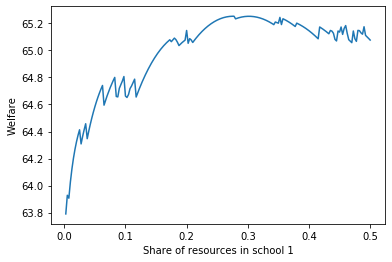

In [67]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 0, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

0.5675


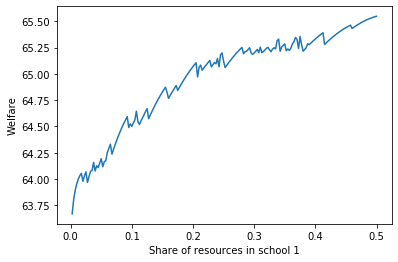

In [68]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 0.1, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

0.5575


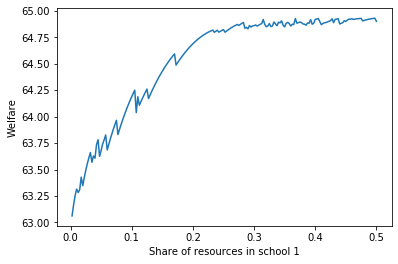

In [69]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 0.25, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

0.3625


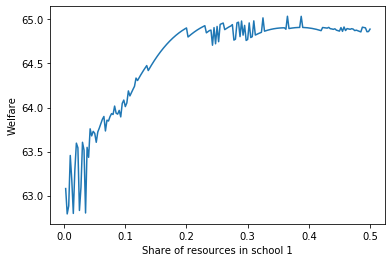

In [70]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 0.5, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

0.03


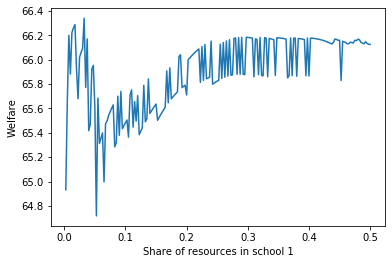

In [71]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 1, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

0.025


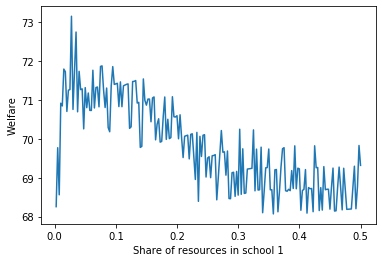

In [72]:
res = simulation_short_uniform_with_reserved_sq_folds(100, 40, 2, folds=400)
print(res[1])
plt.xlabel("Share of resources in school 1")
plt.ylabel("Welfare")
plt.plot(x, res[0])

### Addining $\delta$

$\alpha = 0.01$

In [73]:
perm = 100
all_welf = np.zeros(perm)
all_welf_diffs = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_with_reserved_sq(100, 40, 0.5, increment=0.01)
    all_welf[i] = res[0]
    all_welf_diffs[i] = res[1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.81it/s]


(array([ 5., 20., 11., 11., 23., 19.,  6.,  2.,  1.,  2.]),
 array([0.22503412, 0.27186973, 0.31870533, 0.36554093, 0.41237654,
        0.45921214, 0.50604775, 0.55288335, 0.59971896, 0.64655456,
        0.69339016]),
 <a list of 10 Patch objects>)

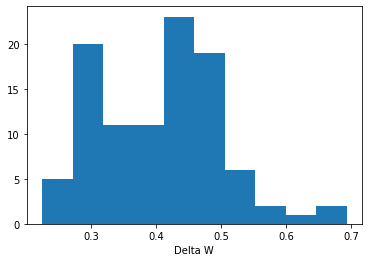

In [75]:
plt.xlabel('Delta W')
plt.hist(all_welf)

(array([ 3.,  2.,  1., 15., 25., 20., 12., 14.,  5.,  3.]),
 array([-0.41251611, -0.35171374, -0.29091138, -0.23010901, -0.16930664,
        -0.10850427, -0.0477019 ,  0.01310047,  0.07390283,  0.1347052 ,
         0.19550757]),
 <a list of 10 Patch objects>)

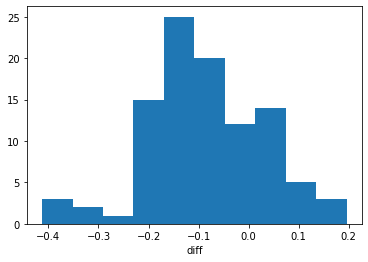

In [76]:
plt.xlabel('diff')
plt.hist(all_welf_diffs)

$\alpha=0.05$

In [77]:
perm = 100
all_welf = np.zeros(perm)
all_welf_diffs = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_with_reserved_sq(100, 40, 0.5, increment=0.05)
    all_welf[i] = res[0]
    all_welf_diffs[i] = res[1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


(array([17., 20., 26., 14., 10.,  8.,  1.,  1.,  2.,  1.]),
 array([1.63955255, 1.71353629, 1.78752004, 1.86150378, 1.93548752,
        2.00947127, 2.08345501, 2.15743876, 2.2314225 , 2.30540624,
        2.37938999]),
 <a list of 10 Patch objects>)

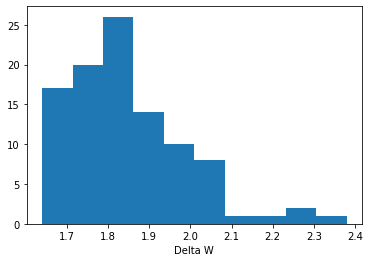

In [78]:
plt.xlabel('Delta W')
plt.hist(all_welf)

(array([ 2.,  2.,  3.,  8.,  6., 21., 22., 13., 18.,  5.]),
 array([-0.92380044, -0.82738152, -0.7309626 , -0.63454368, -0.53812476,
        -0.44170585, -0.34528693, -0.24886801, -0.15244909, -0.05603017,
         0.04038874]),
 <a list of 10 Patch objects>)

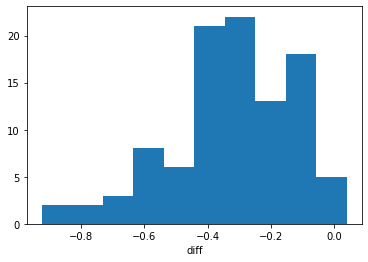

In [79]:
plt.xlabel('diff')
plt.hist(all_welf_diffs)

$\alpha = 0.1$

In [80]:
perm = 100
all_welf = np.zeros(perm)
all_welf_diffs = np.zeros(perm)

for i in tqdm(range(perm)):
    res = simulation_short_uniform_with_reserved_sq(100, 40, 0.5, increment=0.1)
    all_welf[i] = res[0]
    all_welf_diffs[i] = res[1]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


(array([ 1.,  6., 15., 28., 23., 21.,  2.,  3.,  0.,  1.]),
 array([2.93995959, 3.08457715, 3.22919471, 3.37381227, 3.51842983,
        3.66304739, 3.80766495, 3.95228251, 4.09690007, 4.24151764,
        4.3861352 ]),
 <a list of 10 Patch objects>)

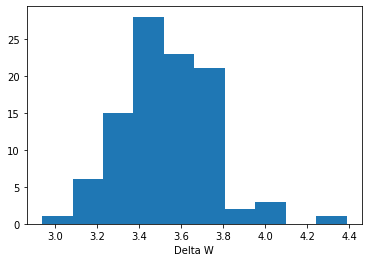

In [81]:
plt.xlabel('Delta W')
plt.hist(all_welf)

(array([ 1.,  2.,  1.,  6.,  8., 17., 24., 21., 15.,  5.]),
 array([-1.39199494, -1.25470948, -1.11742401, -0.98013855, -0.84285308,
        -0.70556761, -0.56828215, -0.43099668, -0.29371121, -0.15642575,
        -0.01914028]),
 <a list of 10 Patch objects>)

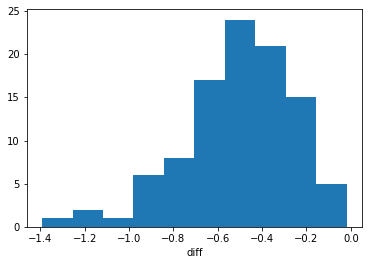

In [82]:
plt.xlabel('diff')
plt.hist(all_welf_diffs)

# Model 2

## Strategy

In [186]:
def drop_loosers(R, W, sch1, sch2, loosers, n, u0):
    
    for i in range(n):
        
        min_utility = min(utility(i, R, W, sch1, sch2))
        if min_utility < u0:
            sch1[i], sch2[i], loosers[i] = 0, 0, 1
    return sch1, sch2, loosers

In [189]:
def naive_strategy(n, r, w, school1, school2, loosers, u0_1, u0_2, score):
    u1, u2 = utility(n, r, w, school1, school2)
    
    """ 
    smart - probability of being smart 
    p1, p2 - probabilities of solving a task for smart and dumb students, respectively
    tasks - number of tasks in exam
    r1 - resources at the rich school
    n - number of students
    u0_1, u0_2 - reserve utility smart and dumb, respectively
    
    """
    
    if w[0][n] > score:
        u0 = u0_1
    else:
        u0 = u0_2
    
    if max(u1, u2) < u0:
        school1[n], school2[n], loosers[n] = 0, 0, 1
        
    if (school1[n] != 0) and (u2 > u1):
        school1[n] = 0
        school2[n] = 1
    elif (school2[n] != 0) and (u2 < u1):
        school1[n] = 1
        school2[n] = 0
    return school1, school2, loosers

## Experiments

## Setup 

We would like to present a bit more complex model. What if there is som kind of a unified state exam, which defines the abilities of a student, whicj means that $w_{is} = c, \forall s$. What is more, we will assume that the population of students consists of dumb and smart. Now we will simulate the results of the exam from ~$Bin(k, p_g)$, where $k$ is the number of questions in the exam, $p_g$ is the probability of solving a question for a student from group $g$.

The population consitst of two parts, so each student will be smart with probability $p_s$ and dumb with probability $1 - p_s$. 

We again have a more resourceful school and less resourceful, $R = \{R_1, 1\}, R_1 > 1$. 

We would also specify the vector of $u_0 = \{u_0^s, u_0^d\}$, where $u_0^s >  u_0^d$, it reflects that smart students can get a better job even without an education

In this setup we will be mostly interested in these questions: 

- will there be more smart students in the rich school? 
- will smart students be school-leavers?
- will the average exam score in school 1 be equal to average exam score in school 2?
- will the average exam score of smart people in school 1 be equal to average exam score of smart people in school 2?
- will the average exam score of dumb people in school 1 be equal to average exam score of smart people in school 2?

In [190]:
def binom_weights_2_groups_ege(smart, p1, p2, tasks, k, s=2):
    
    """

    smart - probability of being smart 
    p1, p2 - probabilities of solving a task for smart and dumb students, respectively
    tasks - number of tasks in exam
    k - number of students
    
    """
    
    W = [np.zeros(k), np.zeros(k)]
    for i in range(k):
        
        if ss.uniform.rvs() < smart:
            res_exam = ss.binom.rvs(n=tasks, p = p1)
            
        else:
            res_exam = ss.binom.rvs(n=tasks, p = p2)
            
        W[0][i], W[1][i] = res_exam, res_exam
        
    return W

We will test 3 hypotheses on each sample

1) $$ H_0^1: \mu_{sch1}=\mu_{sch2}, H_1^1: \mu_{sch1} \neq \mu_{sch2}$$

2) $$ H_0^2: \mu_{sch1 smart}=\mu_{sch2 smart}, H_1^2: \mu_{sch1 smart} \neq \mu_{sch2 smart} $$

3) $$ H_0^3: \mu_{sch1 dumb}=\mu_{sch2 dumb}, H_1^3: \mu_{sch1 dumb} \neq \mu_{sch2 dumb}$$

Because we do multiple testing, we should apply correction of multiple testing. One of such methods is Bonferroni-Holm correction, which is uniformly more powerful than the naive Bonferroni correction. 

Level of significance is $\alpha=0.05$

And after some bootstrap repetions of the simulation we will also test if:
$$ H_0: \# \text{(smart students in rich school)} = \# \text{(smart students in dumb school)}, $$
$$ H_1: \# \text{(smart students in rich school)} \neq \# \text{(smart students in dumb school)}$$

where $\#$ denotes the power of a set

In [191]:
def multiple_hypothesis_test(school_1, school_2, crytical_score_exam=50):
    smart_ass_school_1, smart_ass_school_2 = school_1[school_1 > crytical_score_exam], school_2[school_2 > crytical_score_exam]
    dumb_ass_school_1, dumb_ass_school_2 = school_1[school_1 < crytical_score_exam], school_2[school_2 < crytical_score_exam]
    
    p_val_means = ss.ttest_ind(school_1, school_2, equal_var=False).pvalue
    p_val_means_smartass = ss.ttest_ind(smart_ass_school_1, smart_ass_school_2, equal_var=False).pvalue
    p_val_means_dumbass = ss.ttest_ind(dumb_ass_school_1, dumb_ass_school_2, equal_var=False).pvalue
    
    pvals = [p_val_means, p_val_means_smartass, p_val_means_dumbass]
    hb_test_res = multipletests(pvals=pvals, alpha=0.05, method='holm')
    
    return hb_test_res

We will call a person smart if their exam result is better than: $$ score > \mathbb{E}(smart score) - 3 \sigma(smart score) =  p_s k - 1.5 \sqrt{(n p_s (1 - p_s))}$$ which is 93% share of 3 $\sigma$ rule for the distribution of smart students. 

In [192]:
def simulation_short_binom_2_groups_ege_with_reserved(smart, p1, p2, tasks, r1, n, u0_1, u0_2, perm = 10000, periods = 5, r2=1):
    
    """ 
    smart - probability of being smart 
    p1, p2 - probabilities of solving a task for smart and dumb students, respectively
    tasks - number of tasks in exam
    r1 - resources at the rich school
    n - number of students
    u0_1, u0_2 - reserve utility smart and dumb, respectively
    
    """
    
    R = np.array([r1, 1])
    W = binom_weights_2_groups_ege(smart, p1, p2, tasks, n, s=2)
    
    smart_ass_score = p1 * tasks - 1.5 * (n*p1*(1 - p1)) ** 0.5 # забираем топ-93% студентов, используя правило 2х сигм
    
    stud = students(n)
    sch1, sch2 = initial_allocation(students(n))
    
    list_of_quits = np.zeros(n)
    
    
    check = check_equilibrium(R, W, sch1, sch2)
    
    j = 0
    while check != 1:
        person = j % n 
        sch1, sch2, list_of_quits = naive_strategy(person, R, W, sch1, sch2, list_of_quits, u0_1, u0_2, smart_ass_score) 
        check = check_equilibrium(R, W, sch1, sch2)
        j += 1

    sch1, sch2 = np.array(sch1), np.array(sch2)
    
    num_students_sch1, num_students_sch2, num_students_left = np.sum(sch1), np.sum(sch2), np.sum(list_of_quits)
    average_score_sch1, average_score_sch2, average_score_left = np.sum((sch1 * W[0]) / np.sum(sch1)), np.sum((sch2 * W[1]) / np.sum(sch2)), np.sum((list_of_quits * W[0]) / np.sum(list_of_quits))
    
    num_smart_ass_sch1, num_smart_ass_sch2, num_smart_ass_left = sch1 * W[0], sch2 * W[1], list_of_quits * W[0]
    num_smart_ass_sch1 = len(num_smart_ass_sch1[num_smart_ass_sch1 > smart_ass_score])
    num_smart_ass_sch2 = len(num_smart_ass_sch2[num_smart_ass_sch2 > smart_ass_score])
    num_smart_ass_left = len(num_smart_ass_left[num_smart_ass_left > smart_ass_score])
    
    for_dist_sch1, for_dist_sch2, for_dist_left = sch1 * W[0], sch2 * W[1], list_of_quits * W[0]
    for_dist_sch1 = for_dist_sch1[for_dist_sch1 > 0]
    for_dist_sch2 = for_dist_sch2[for_dist_sch2 > 0]
    for_dist_left = for_dist_left[for_dist_left > 0]
    
    stat_test_res = multiple_hypothesis_test(for_dist_sch1, for_dist_sch2)[0]
        
    return num_students_sch1, num_students_sch2, num_students_left, average_score_sch1, average_score_sch2, average_score_left, num_smart_ass_sch1, num_smart_ass_sch2, num_smart_ass_left, for_dist_sch1, for_dist_sch2, for_dist_left, stat_test_res,check

In [193]:
smart = 0.2
p1, p2 = 0.8, 0.4
tasks = 100
r1, r2 = 2, 1 
n = 100
u0_1, u0_2 = 2 * (r1 + r2) / n, (r1 + r2) / n

In [194]:
res = simulation_short_binom_2_groups_ege_with_reserved(smart=smart, p1=p1, p2=p2, tasks=tasks, r1=r1, n=n, u0_1=u0_1, u0_2=u0_2)

In [195]:
school_1, school_2 = res[9], res[10]
smart_ass_school_1, smart_ass_school_2 = school_1[school_1 > 50], school_2[school_2 > 50]
dumb_ass_school_1, dumb_ass_school_2 = school_1[school_1 < 50], school_2[school_2 < 50]

In [196]:
p_val_means = ss.ttest_ind(school_1, school_2, equal_var=False).pvalue
p_val_means_smartass = ss.ttest_ind(smart_ass_school_1, smart_ass_school_2, equal_var=False).pvalue
p_val_means_dumbass = ss.ttest_ind(dumb_ass_school_1, dumb_ass_school_2, equal_var=False).pvalue

Setup and input
Smart probability: 0.2; p1, p2: (0.8, 0.4); number of students: 100
Number of tasks in the exam: 100. Resources (R1, R2): (2, 1)
Reserve Utility smart: 0.06; Reserve Utility dumb: 0.03
===
Experiment results
Number of students in school1, school2, left: 58.0, 28.0, 14.0
Mean score in school1, school2, left: 50.966, 52.071, 43.286
Number of smart students in school1, school2, left: 16, 7, 1
Exit code: 1
===
Distribution of exam results in school 1


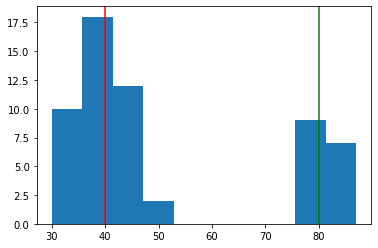

Distribution of exam results in school 2


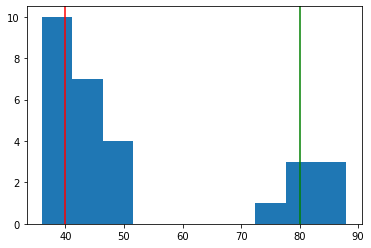

Distribution of exam results in left


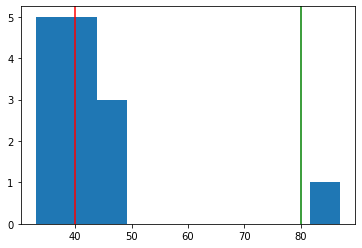

===
Tests results
p-value t-test for equal means in two schools: 0.7922913912276547
p-value t-test for equal smart means in two schools: 0.7935907918531739
p-value t-test for equal dumb means in two schools: 0.007092472155070762


In [199]:
print('Setup and input')
print(f'Smart probability: {smart}; p1, p2: ({p1}, {p2}); number of students: {n}')
print(f'Number of tasks in the exam: {tasks}. Resources (R1, R2): ({r1}, {r2})')
print(f'Reserve Utility smart: {u0_1}; Reserve Utility dumb: {u0_2}')
# print(f'Количество периодов: {periods}')
print('===')
print('Experiment results')
print(f'Number of students in school1, school2, left: {res[0]}, {res[1]}, {res[2]}')
print(f'Mean score in school1, school2, left: {round(res[3], 3)}, {round(res[4], 3)}, {round(res[5], 3)}')
print(f'Number of smart students in school1, school2, left: {res[6]}, {res[7]}, {res[8]}')
print(f'Exit code: {res[-1]}')
print('===')
print('Distribution of exam results in school 1')
plt.hist(res[9])
plt.axvline(x=tasks * p2, color='r')
plt.axvline(x=tasks * p1, color='g')
plt.show()
print('Distribution of exam results in school 2')
plt.hist(res[10])
plt.axvline(x=tasks * p2, color='r')
plt.axvline(x=tasks * p1, color='g')
plt.show()
print('Distribution of exam results in left')
plt.hist(res[11])
plt.axvline(x=tasks * p2, color='r')
plt.axvline(x=tasks * p1, color='g')
plt.show()
print('===')
print('Tests results')
print(f'p-value t-test for equal means in two schools: {p_val_means}')
print(f'p-value t-test for equal smart means in two schools: {p_val_means_smartass}')
print(f'p-value t-test for equal dumb means in two schools: {p_val_means_dumbass}')

We see that in our model it is possible that smart students leave school. 

## Test $H_0$

We will count the bootstrap probability of rejecting $H_0^i$

In [200]:
iterations = 1000

all_number_of_smart_sch1 = np.zeros(iterations)
all_number_of_smart_sch2 = np.zeros(iterations)

number_of_rejected_mean = 0
number_of_rejected_mean_smart = 0
number_of_rejected_mean_dumb = 0

for i in tqdm(range(iterations)):
    try: 
        res = simulation_short_binom_2_groups_ege_with_reserved(smart=smart, p1=p1, p2=p2, tasks=tasks, r1=r1, n=n, u0_1=u0_1, u0_2=u0_2)
        number_of_rejected_mean += res[12][0]
        number_of_rejected_mean_smart += res[12][1]
        number_of_rejected_mean_dumb += res[12][2]

        all_number_of_smart_sch1[i], all_number_of_smart_sch2[i] = res[6], res[7]
    except RuntimeWarning:
        continue

print(f'Share of rejected H0 for means: {number_of_rejected_mean / iterations}')
print(f'Share of rejected H0 for means between smart students: {number_of_rejected_mean_smart / iterations}')
print(f'Share of rejected H0 for means between dumb students: {number_of_rejected_mean_dumb / iterations}')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:08<00:00,  5.31it/s]

Share of rejected H0 for means: 0.021
Share of rejected H0 for means between smart students: 0.011
Share of rejected H0 for means between dumb students: 0.064


We conclude that we significantly rare reject the null hypothesis for means between schools and means between smart students. It means that it is sometimes better to be best at poor school rather than compete for resources in a rich one. 

In [142]:
ss.ttest_ind(all_number_of_smart_sch1, all_number_of_smart_sch2, equal_var=False, alternative='greater').pvalue

0.0

This tests shows that it the richer school there are a significantly more smart students than in the poor one.